In [1]:
import sys
import rootpath
sys.path.append(rootpath.detect())
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Patch
from testsuite.utilities import dominates
from testsuite.utilities import saf
from pymoo.factory import get_performance_indicator
from tqdm import tqdm
import time
import matplotlib.image as mpimg


In [3]:
matplotlib.rcParams['mathtext.fontset'] = 'stix';
matplotlib.rcParams['font.family'] = 'STIXGeneral';
matplotlib.rcParams['font.size'] = 15 ;
matplotlib.rcParams['legend.fontsize'] = 15
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

COLORS = {
    "a": '#ffa500',
    "b": '#008000',
    "v_b": '#a1d0a1', 
    "v_br": '#e6f2e6',
    "v_a": '#ffdda1',
    "v_ar": '#fff6e6'
}
CMAP_VA = matplotlib.colors.ListedColormap(['None', COLORS['a']])
CMAP_VB = matplotlib.colors.ListedColormap(['None', COLORS['b']])

In [4]:
def save_fig(fig, filename):
    d = "./figures/"
    path = os.path.join(d, filename)
    fig.savefig(path+".png", dpi=300, facecolor=None, edgecolor=None, orientation='portrait', 
                pad_inches=0.12)

In [5]:
def volume_a(y, targets, p, rp):
    """
    do elements in y belong to volume a, True if 
        - are dominated by any of targets
        - dominate the reference point
        - are dominated by any of p
    """
    va = np.asarray([dominates(targets, yi) and dominates(xyi, rp) and dominates(p, yi)  for yi in y.flat])
    return va

def volume_b(y, targets, p, rp):
    """
    do elements in y belong to volume b, True if 
        - dominate any of targets
        - are dominated by any of p
    """
    vb = np.asarray([np.any([dominates(yi, t) for t in targets]) and dominates(p, xyi) for yi in y])
    return vb

In [6]:
def image_case(case, ref_volume=False, resolution=200, ax=None):
    """
    returns figure showing volumes Va and Vb from the case desribed
    by case. 
    
    :param case: dict
        dictionary containing case definition
    :param ref_volume: bool
        If true show the outer volumes of which Va and Vb should be 
        calculated as a fraction. Defaults to false as calculating
        these is slow (due to many dominantion relation checks in
        the Pareto front)
    :param resolution: int
        image resoution, keep low (~50) for speed increase. 
    """

    if ax is None:
        fig = plt.figure(figsize=[6, 6])
        ax = fig.gca() 
        return_fig = Tue
    else:
        return_fig = False
        
    ax.grid('on')
    ax.axis("scaled")
    ax.set_xticks(range(0,12)) 
    ax.set_yticks(range(0,12)) 
    ax.legend(loc="lower left")
    
    x_lim = ax.get_xlim()
    x = np.linspace(0,x_lim[1], resolution)
    y_lim = ax.get_ylim()
    y = np.linspace(*y_lim, resolution)
    xx, yy = np.meshgrid(x, y)
    xy = np.vstack((xx.flat, yy.flat)).T
    zz = saf(xy, case['p']).reshape(resolution, resolution) 
    
    P_x = x
    P_y = 5/x
    t_ideal = case['target'].min(axis=0)
    t_az = case['target'].max(axis=0)
    
    # generate boolean masks for volumes of interest: Va and Vb
    va = np.asarray([dominates(case['target'], xyi) and dominates(xyi, case['ref_point']) and dominates(case['p'], xyi)  for xyi in xy])
    vb = np.asarray([np.any([dominates(xyi, t) for t in case['target']]) and dominates(case['p'], xyi) for xyi in xy])
    
    if ref_volume:
        va_r = np.asarray([dominates(case['target'], xyi) and dominates(xyi, case['ref_point']) for xyi in xy])
        vb_r = np.asarray([np.any([dominates(pi, xyi) for pi in np.vstack((P_x, P_y)).T]) and np.any([dominates(xyi, t) for t in case['target']]) for xyi in xy])

    
    
    a = ax.get_xlim()
    b = ax.get_ylim()
    vol_a = ax.imshow(va.reshape(resolution,resolution)[::-1, :], alpha=0.3, extent=[0, 11, 0, 11], cmap=CMAP_VA)
    vol_b = ax.imshow(vb.reshape(resolution,resolution)[::-1, :], alpha=0.3, extent=[*ax.get_xlim(), *ax.get_ylim()], cmap=CMAP_VB)
    
    if ref_volume:
        vol_ar = ax.imshow(va_r.reshape(resolution,resolution)[::-1, :], alpha=0.1, extent=[0, 11, 0, 11], cmap=CMAP_VA)
        vol_br = ax.imshow(vb_r.reshape(resolution,resolution)[::-1, :], alpha=0.1, extent=[0, 11, 0, 11], cmap=CMAP_VB)
    
    ax.contour(xx, yy, zz, levels=[0.], colors="C0", alpha=0.5)
    
    
    ax.scatter(*case['p'].T, c="C0", label=r"$\tilde{P}$")
    ax.scatter(*case['target'].T, c="magenta", label=r"$T$")
    ax.scatter(*case['ref_point'], c="C3", label=r"$r$")
    
    ax.scatter(*t_ideal, c="magenta", label=r"$\tilde{t}$", marker="*")
    ax.scatter(*t_az, c="magenta", label=r"$\check{t}$", marker="v")
    
    ax.hlines(t_ideal[1], t_ideal[0], t_az[0], colors="magenta", linestyle="--", alpha=0.2)
    ax.hlines(t_az[1], t_ideal[0], t_az[0], colors="magenta", linestyle="--", alpha=0.2)
    ax.vlines(t_ideal[0], t_ideal[1], t_az[1], colors="magenta", linestyle="--", alpha=0.2)
    ax.vlines(t_az[0], t_ideal[1], t_az[1], colors="magenta", linestyle="--", alpha=0.2)
    
    
    ax.plot(P_x, P_y, c="k", label=r"$P$")
    handles, labels = ax.get_legend_handles_labels()
    handles += [plt.Line2D([0], [0], c="C0", alpha=0.5)]
    handles += [Patch(facecolor="orange", alpha=0.4), Patch(facecolor="green", alpha=0.3)]
    labels += [r"$A$", r"$V_a$", r"$V_b$"]
    nc = 3
    
    if ref_volume:
        handles += [Patch(facecolor="orange", alpha=0.1), Patch(facecolor="green", alpha=0.1)]
        labels += [r"$V_{ar}$", r"$V_{br}$"]
        
        nc = 4
    
    
    ax.legend(handles, labels, loc="lower left", ncol=nc) 
    
    if ref_volume:
        va_frac = (np.sum(va)/np.sum(va_r)).round(3)
        vb_frac = (np.sum(vb)/np.sum(vb_r)).round(3)
    else:    
        va_frac = (np.sum(va)/len(va)).round(3)
        vb_frac = (np.sum(vb)/len(vb)).round(3)
        
    pos_a = np.vstack(np.where(va.reshape(resolution, resolution))).T.mean(axis=0)/resolution*(np.array([x_lim[1]-x_lim[0], y_lim[1]-y_lim[0]]))
    pos_b = np.vstack(np.where(vb.reshape(resolution, resolution))).T.mean(axis=0)/resolution*(np.array([x_lim[1]-x_lim[0], y_lim[1]-y_lim[0]]))
    
    if ref_volume:
        ax.text(pos_a[1], pos_a[0], fr"$M_a={va_frac}$", c=CMAP_VA.colors[1])
        ax.text(pos_b[1], pos_b[0], fr"$M_b={vb_frac}$", c=CMAP_VB.colors[1])
    else:
        ax.text(pos_a[1], pos_a[0], fr"$V_a={va_frac}$", c=CMAP_VA.colors[1])
        ax.text(pos_b[1], pos_b[0], fr"$V_b={vb_frac}$", c=CMAP_VB.colors[1])
    
    ax.set_xlabel(r"$f_1$")
    ax.set_ylabel(r"$f_2$")
    
    if return_fig:
        return fig

In [7]:
def montecarlo_case(case, samples=1e6, ax=None):
    """
    :param case: dict
        dictionary containing case definition
    :param ref_volume: bool
        If true show the outer volumes of which Va and Vb should be 
        calculated as a fraction. Defaults to false as calculating
        these is slow (due to many dominantion relation checks in
        the Pareto front)
    :param resolution: int
        image resoution, keep low (~50) for speed increase. 
    """
    samples = int(samples)
    resolution = int(np.sqrt(samples)/5)
    
    if ax is None:
        fig = plt.figure(figsize=[6, 6])
        ax = fig.gca() 
        return_fig = Tue
    else:
        return_fig = False
        
    ax.grid('on')
    ax.axis("scaled")
    ax.set_xticks(range(0,12)) 
    ax.set_yticks(range(0,12)) 
    ax.legend(loc="lower left")
    
    x_lim = ax.get_xlim()
    x = np.linspace(0,x_lim[1], resolution)
    y_lim = ax.get_ylim()
    y = np.linspace(*y_lim, resolution)
    xx, yy = np.meshgrid(x, y)
    xy = np.vstack((xx.flat, yy.flat)).T
    zz = saf(xy, case['p']).reshape(resolution, resolution) 
    
    xy = np.vstack([np.random.uniform(0, i, samples) for i in case['ref_point']]).T
    
    P_x = x
    P_y = 5/x
    t_ideal = case['target'].min(axis=0)
    t_az = case['target'].max(axis=0)
    
    va_r = xy[[dominates(case['target'], xyi) and dominates(xyi, case['ref_point']) for xyi in xy]]
    vb_r = xy[[np.any([dominates(pi, xyi) for pi in np.vstack((P_x, P_y)).T]) and np.any([dominates(xyi, t) for t in case['target']]) for xyi in xy]]
    va = va_r[[dominates(case['target'], xyi) and dominates(xyi, case['ref_point']) and dominates(case['p'], xyi)  for xyi in va_r]]
    vb = vb_r[[np.any([dominates(xyi, t) for t in case['target']]) and dominates(case['p'], xyi) for xyi in vb_r]]
    
    ax.scatter(*va_r.T, c=COLORS['v_ar'], label=r"$V_{ar}$", s=5)
    ax.scatter(*vb_r.T, c=COLORS['v_br'], label=r"$V_{br}$", s=5)
    ax.scatter(*va.T, c=COLORS['v_a'], label=r"$V_{a}$", s=5)
    ax.scatter(*vb.T, c=COLORS['v_b'], label=r"$V_{b}$", s=5)
    
     
    t_ideal = case['target'].min(axis=0)
    t_az = case['target'].max(axis=0)
    
    ax.contour(xx, yy, zz, levels=[0.], colors="C0", alpha=0.5)
    
    
    ax.scatter(*case['p'].T, c="C0", label=r"$\tilde{P}$")
    ax.scatter(*case['target'].T, c="magenta", label=r"$T$")
    ax.scatter(*case['ref_point'], c="C3", label=r"$r$")
    
    ax.scatter(*t_ideal, c="magenta", label=r"$\tilde{t}$", marker="*")
    ax.scatter(*t_az, c="magenta", label=r"$\check{t}$", marker="v")
    
    ax.hlines(t_ideal[1], t_ideal[0], t_az[0], colors="magenta", linestyle="--", alpha=0.2)
    ax.hlines(t_az[1], t_ideal[0], t_az[0], colors="magenta", linestyle="--", alpha=0.2)
    ax.vlines(t_ideal[0], t_ideal[1], t_az[1], colors="magenta", linestyle="--", alpha=0.2)
    ax.vlines(t_az[0], t_ideal[1], t_az[1], colors="magenta", linestyle="--", alpha=0.2)
    
    ax.plot(P_x, P_y, c="k", label=r"$P$")
    nc =  int(np.ceil(len(ax.get_legend_handles_labels()[0])/3))
    handles, labels = ax.get_legend_handles_labels()
    handles += [plt.Line2D([0], [0], c="C0", alpha=0.5)]
    labels += [r"$A$"]
    ax.legend(handles, labels, ncol=nc, loc="lower left")
    
    va_frac = np.round(len(va)/len(va_r), 3)
    vb_frac = np.round(len(vb)/len(vb_r), 3)
        
    print(va_frac)
    print(vb_frac)   
    pos_a = va.mean(axis=0) 
    pos_b = vb.mean(axis=0) 
    
    ax.text(pos_a[0], pos_a[1], fr"$M_a={va_frac}$", c="k")
    ax.text(pos_b[0], pos_b[1], fr"$M_b={vb_frac}$", c="k")
    
    ax.set_xlabel(r"$f_1$")
    ax.set_ylabel(r"$f_2$")
    
    
    if return_fig:
        return fig

### Nomanclature 
* $P$: Pareto front
* $\tilde{P}$: Approximation to Pareto front: $\tilde{P} = \{y_i\}^n_{i=1}$
* $A$: attainment front
* $r$: reference point
* $T$: targets: $T = \{t_i\}^{n_t}_{i=1}$
* $\tilde{t}$: target ideal $\tilde{t} = \{\tilde{t}_j\}_{j=1}^n$  where: $$\tilde{t}_j = \min_{u \in T}\{u_j\}$$
* $\check{t}$: target zenith $\check{t} = \{\check{t}_j\}_{j=1}^n$ where: $$\check{t}_j = \max_{u \in T}\{u_j\}$$


* $H(Y, r)$: Volume dominated by $Y$ referred to $r$

Region that is dominated by a set $Z$ in objective space:

$$ 
\mbox{dom}(Z) = \{ u \,|\, \exists z \in Z ~ s.t. ~ z \prec u \}
$$

### Volume definitions

$$
V_a = H(\mbox{dom}(T) \cap \mbox{dom}(\tilde{P}), r)
$$

$$ 
V_b = H(\mbox{dom}(\tilde{P}) \setminus \mbox{dom}(\check{t}), r)
$$

### Reference Volume definitions

$$
V_{ar} = H(\mbox{dom}(T) \cap \mbox{dom}(P), r)
$$

$$
V_{br} = H(\mbox{dom}(P) \setminus \mbox{dom}(\check{t}), r)
$$

### Relative Hypervolume Scores 
$$
M_a = \frac{V_a}{V_{ar}} = \frac{H(\mbox{dom}(T) \cap \mbox{dom}(\tilde{P}), r)}{H(\mbox{dom}(T) \cap \mbox{dom}(P), r)}
$$

$$
M_b = \frac{V_b}{V_{br}} = \frac{H(\mbox{dom}(\tilde{P}) \setminus \mbox{dom}(\check{t}), r)}{H(\mbox{dom}(P) \setminus \mbox{dom}(\check{t}), r)} 
$$

# REVISED

### Volume definitions

$$
V_a = H(\mbox{dom}(T) \cap \mbox{dom}(\tilde{P}), r)
$$

$$ 
V_b = H(\mbox{dom}(\tilde{P}) \setminus \mbox{dom}(\tilde{t}), \check{t})
$$

### Reference Volume definitions

$$
V_{ar} = H(\mbox{dom}(T) \cap \mbox{dom}(P), r)
$$

$$
V_{br} = H(\mbox{dom}(P) \setminus \mbox{dom}(\tilde{t}), \check{t})
$$

### Relative Hypervolume Scores 
$$
M_a = \frac{V_a}{V_{ar}} = \frac{H(\mbox{dom}(T) \cap \mbox{dom}(\tilde{P}), r)}{H(\mbox{dom}(T) \cap \mbox{dom}(P), r)}
$$

$$
M_b = \frac{V_b}{V_{br}} = \frac{H(\mbox{dom}(\tilde{P}) \setminus \mbox{dom}(\tilde{t}), \check{t})}{H(\mbox{dom}(P) \setminus \mbox{dom}(\tilde{t}), \check{t})} 
$$

In [8]:
# define test cases

# single target attained
case_00 = {'ref_point': np.array([10., 10.]),
           'name': 'case_00',
          'target' : np.array([[6., 7.]]),
          'p' : np.array([[1., 7.],
                          [3., 6.],
                          [5., 5.],
                          [7., 4.]]),
          'doh': (12., 4.)
          }

# single target unattained
case_01 = {'ref_point': np.array([10., 10.]),
           'name': 'case_01',
          'target' : np.array([[2., 4.]]),
          'p' : np.array([[1., 7.],
                          [3., 6.],
                          [5., 5.],
                          [7., 4.]]),
          'doh': (39., 0.)
          }

# dual targets, both attained
case_02 = {'ref_point': np.array([10., 10.]),
           'name': 'case_02',
           'target' : np.array([[6., 7.],
                                [8., 5.]
                                ]),
           'p' : np.array([[1., 7.],
                           [3., 6.],
                           [5., 5.],
                           [7., 4.]]),
           'doh': (12., 4.)
          }

# dual targets, both unattained
case_03 = {'ref_point': np.array([10., 10.]),
           'name': 'case_03',
           'target' : np.array([[2., 5.],
                                [5., 3.]
                                ]),
           'p' : np.array([[1., 7.],
                           [3., 6.],
                           [5., 5.],
                           [7., 4.]]),
           'doh': (12., 4.)
          }

# dual targets, one unattained, one unattained
case_04 = {'ref_point': np.array([10., 10.]),
           'name': 'case_04',
           'target' : np.array([[2., 5.],
                                [8., 5.]
                                ]),
           'p' : np.array([[1., 7.],
                           [3., 6.],
                           [5., 5.],
                           [7., 4.]]),
           'doh': (12., 4.)
          }

# dual targets, one unattained, one unattained, attained beyond span of t
case_05 = {'ref_point': np.array([10., 10.]),
           'name': 'case_05',
           'target' : np.array([[8., 3.],
                                [2., 9.]
                               ]),
           'p' : np.array([[1., 7.],
                           [3., 6.],
                           [5., 5.],
                           [7., 4.]]),
           'doh': (12., 4.)
          }

# dual targets, both unattained, one beyond span of p
case_06 = {'ref_point': np.array([10., 10.]),
           'name': 'case_06',
           'target' : np.array([[2., 5.],
                                [0.8, 9.]
                               ]),
           'p' : np.array([[1., 7.],
                           [3., 6.],
                           [5., 5.],
                           [7., 4.]]),
           'doh': (12., 4.)
          }

# dual targets, both unattained, overlapping volumes
case_07 = {'ref_point': np.array([10., 10.]),
           'name': 'case_07',
           'target' : np.array([[2., 4.],
                                [3., 3.]
                               ]),
           'p' : np.array([[1., 7.],
                           [3., 6.],
                           [5., 5.],
                           [7., 4.]]),
           'doh': (12., 4.)
          }

# dual targets, both attained, one beyond span of p
case_08 = {'ref_point': np.array([10., 10.]),
           'name': 'case_08',
           'target' : np.array([[6., 7.],
                                [9, 5.]
                               ]),
           'p' : np.array([[1., 7.],
                           [3., 6.],
                           [5., 5.],
                           [7., 4.]]),
           'doh': (12., 4.)
          }

# dual targets, both attained, overlapping volumes 
case_09 = {'ref_point': np.array([10., 10.]),
           'name': 'case_09',
           'target' : np.array([[5., 8.],
                                [6, 7.]
                               ]),
           'p' : np.array([[1., 7.],
                           [3., 6.],
                           [5., 5.],
                           [7., 4.]]),
           'doh': (12., 4.)
          }

# three targets, one unattained, two unattained, attained beyond span of t
case_10 = {'ref_point': np.array([10., 10.]),
           'name': 'case_10',
           'target' : np.array([[8., 3.],
                                [5., 7.],
                                [2., 9.]
                               ]),
           'p' : np.array([[1., 7.],
                           [3., 6.],
                           [5., 5.],
                           [7., 4.]]),
           'doh': (12., 4.)
          }

case_11 = {'ref_point': np.array([10., 10.]),
           'name': 'case_10',
           'target' : np.array([[4., 9],
                                [6, 8],
                                [8, 7]
                               ]),
           'p' : np.array([[1., 7.],
                           [3., 6.],
                           [5., 5.],
                           [7., 4.]]),
           'doh': (12., 4.)
          }


cases = [case_00,
         case_01,
         case_02,
         case_03,
         case_04,
         case_05,
         case_06,
         case_07,
         case_08,
         case_09,
         case_10,
         case_11]


No handles with labels found to put in legend.
<ipython-input-6-c71c711372c0>:39: RuntimeWarning: divide by zero encountered in true_divide
  P_y = 5/x
No handles with labels found to put in legend.
<ipython-input-7-781db8fff530>:40: RuntimeWarning: divide by zero encountered in true_divide
  P_y = 5/x


0.897
0.118


Text(0.5, 1.0, 'Monte-Carlo sampled volumes')

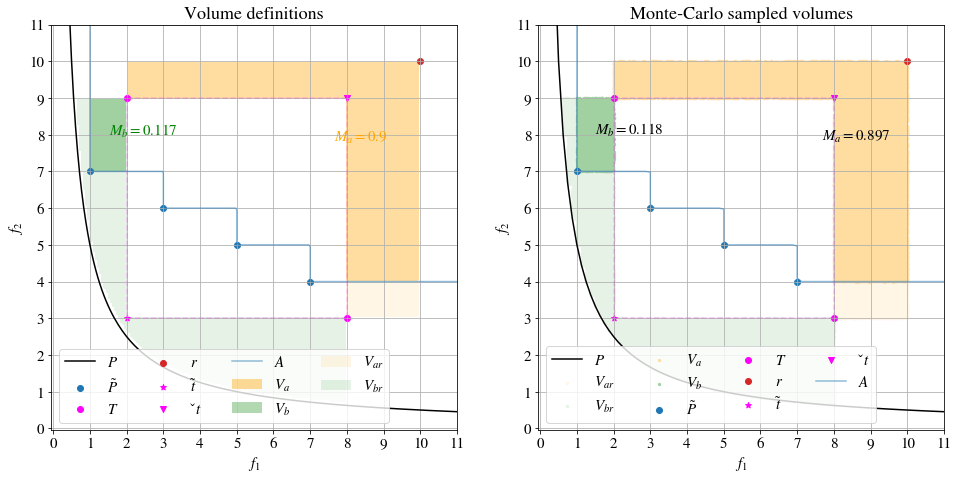

In [9]:
# compute any single case
n_samples = int(2e5)
resolution = int(np.sqrt(n_samples)/5)

case = case_05
tic = time.time()
fig, axes = plt.subplots(1,2, figsize=[16, 8])
image_case(case, True, 200, axes[0])
toc = time.time()
montecarlo_case(case, n_samples, axes[1])

tac = time.time()

axes[0].set_title("Volume definitions")
axes[1].set_title(fr"Monte-Carlo sampled volumes")

  0%|          | 0/12 [00:00<?, ?it/s]<ipython-input-10-65614a33e4f8>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 12/12 [00:06<00:00,  1.83it/s]


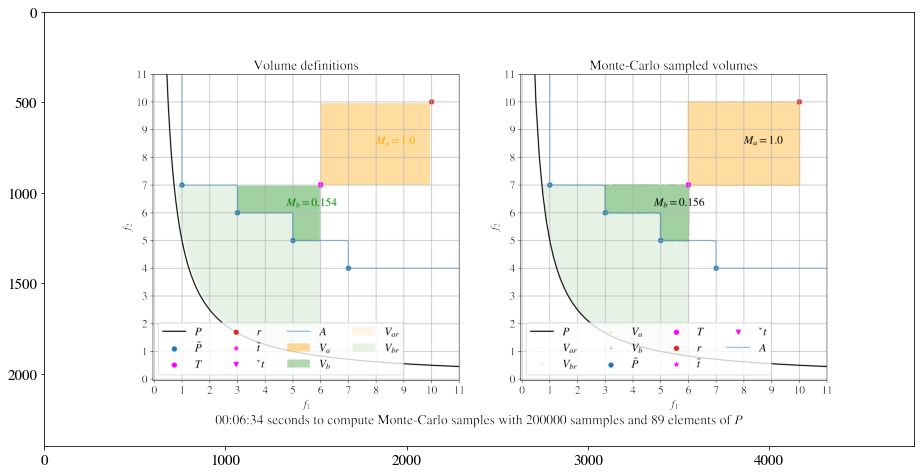

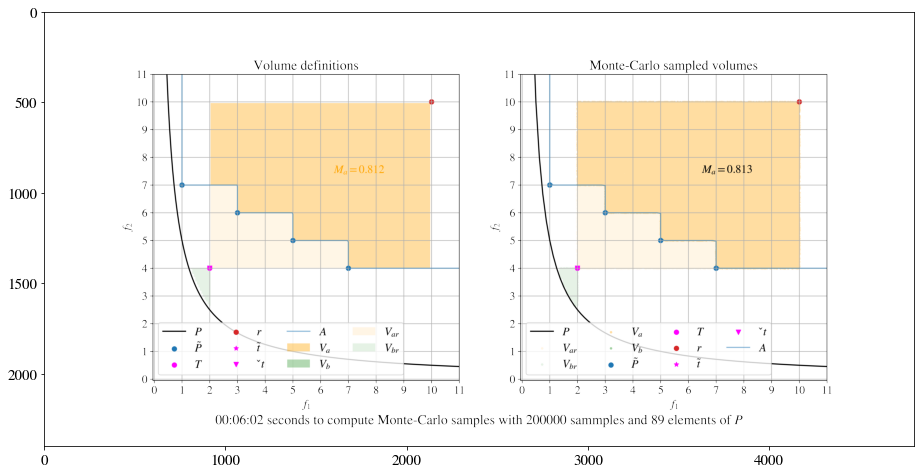

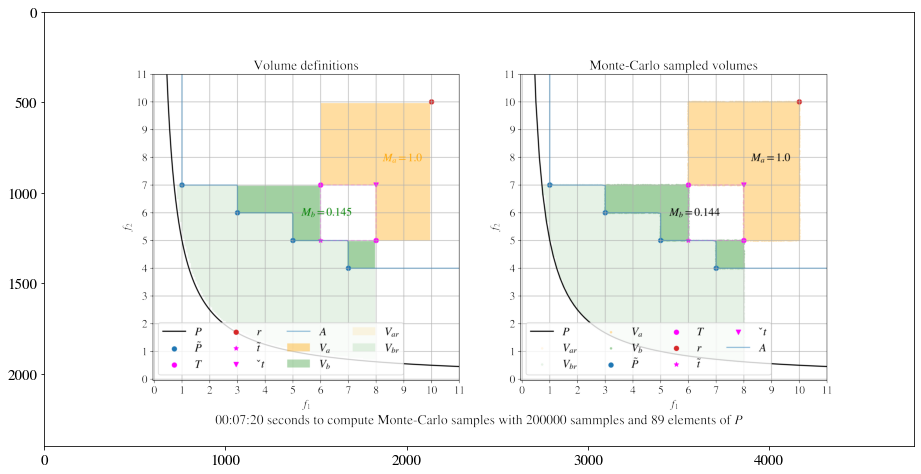

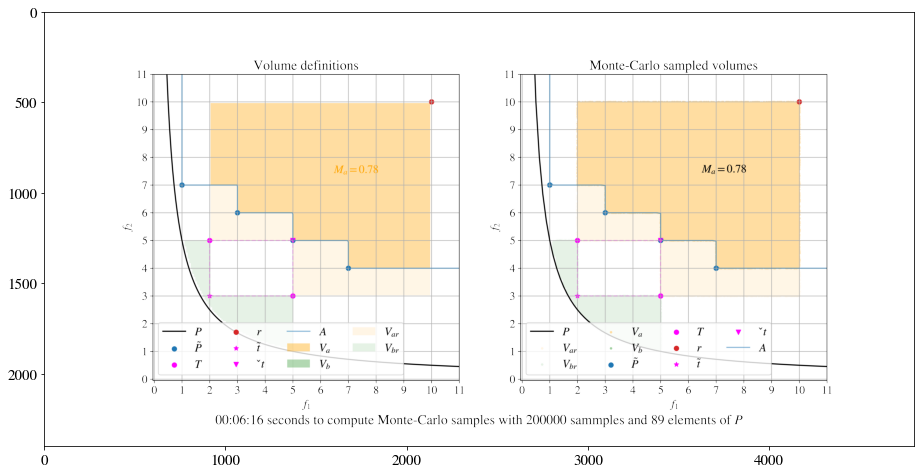

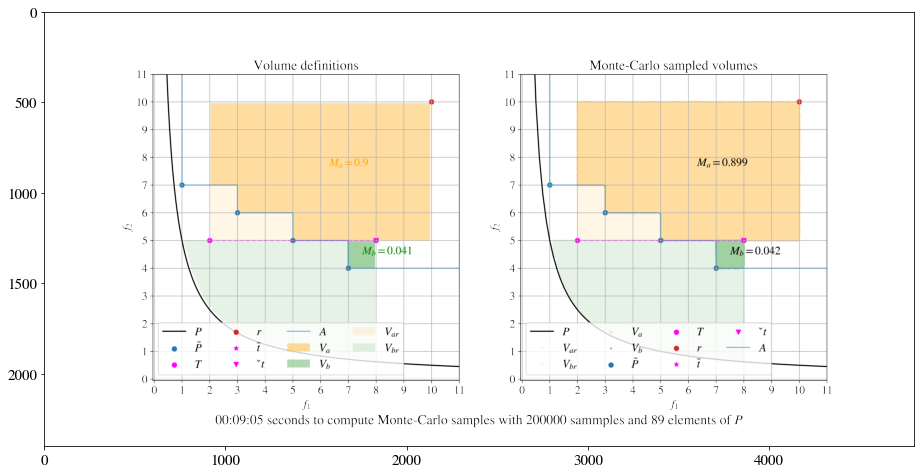

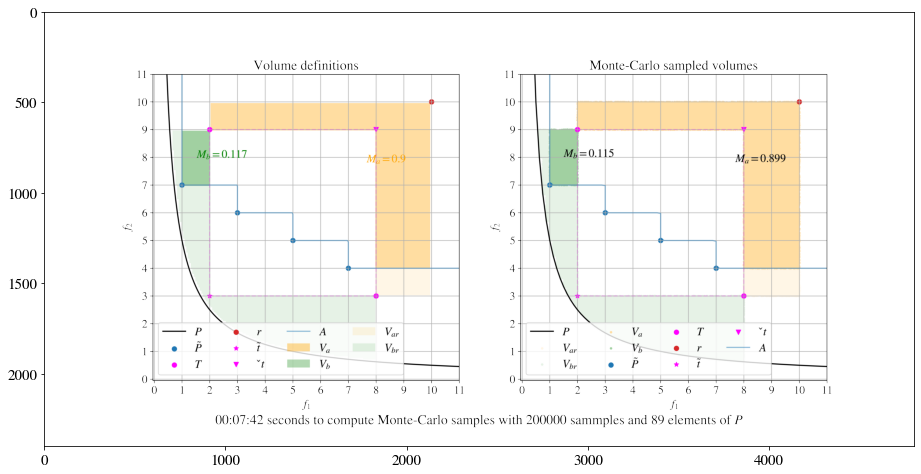

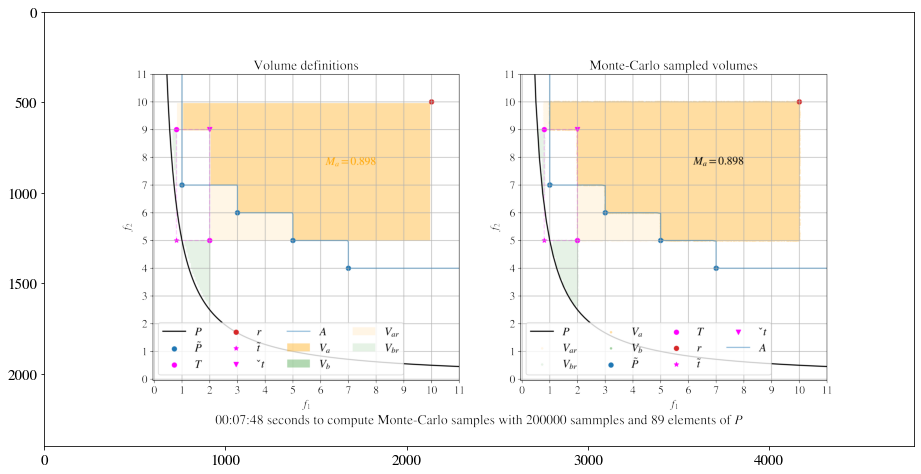

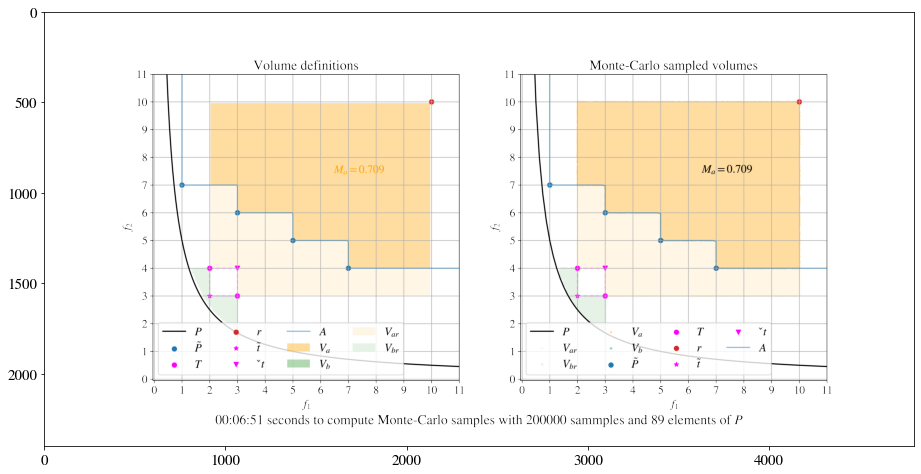

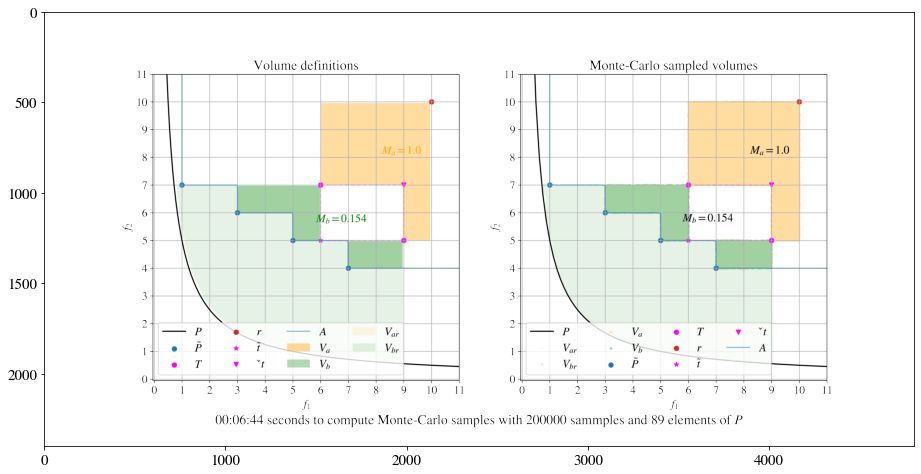

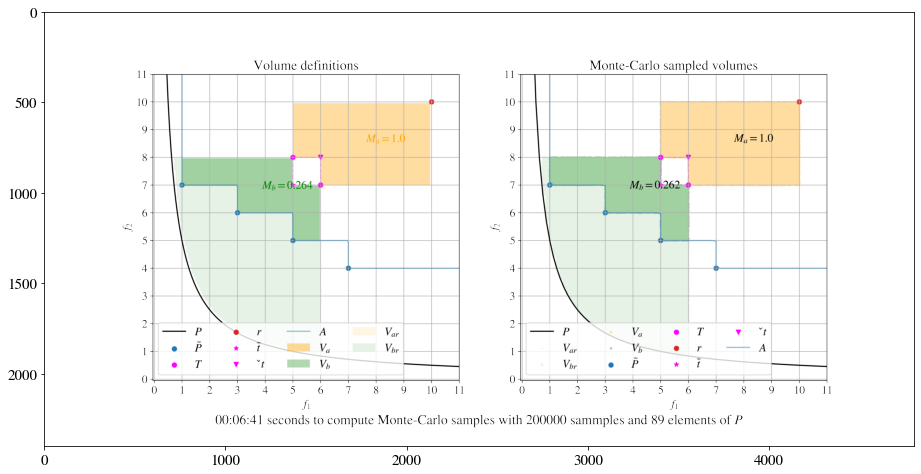

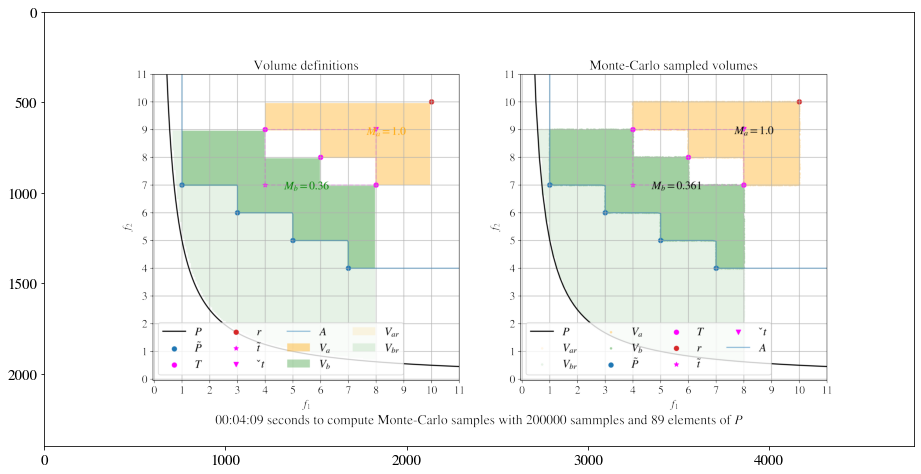

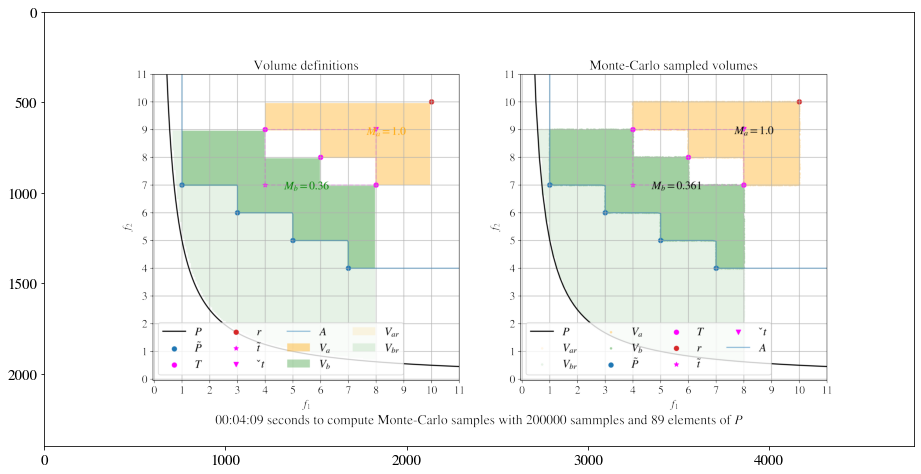

In [10]:
n_samples = int(2e5)
resolution = int(np.sqrt(n_samples)/5)

for case in tqdm(cases):
    case_name = f"figures/{case['name']}.png"
    
    if os.path.isfile(case_name):
        fig = plt.figure(figsize=[16, 8])
        img = mpimg.imread(case_name)
        fig.gca().imshow(img)
    else:
        fig, axes = plt.subplots(1,2, figsize=[16, 8])
        tic=time.time()
        image_case(case, True, 200, axes[0])
        toc = time.time()
        montecarlo_case(case, n_samples, axes[1])
        tac = time.time()
        
        axes[0].set_title("Volume definitions")
        axes[1].set_title(fr"Monte-Carlo sampled volumes")
        
    
        fig.text(0.5, 0.05, fr"{time.strftime('%H:%M:%S', time.gmtime(tac-toc))} seconds to compute Monte-Carlo samples with {n_samples} sammples and {resolution} elements of $P$", ha="center", fontsize=18)
    fig.show()
#     save_fig(fig, case['name']);

# Practical calculation  of $M_a$ and $M_b$:
<!-- ### definitions -->
* dominated(a, b): find the elements of a which are dominated by at least one element of b  
* nondominated(a, b): find the elements of a which are not dominated by at least one element of b  

###  Monte-Carlo:
##### $M_a$
* draw a large number of random uniform samples ($S$) between $\tilde{t}$ and $r$: $S \gets$  np.random.uniform($\tilde{t}$, r, 1e7)
* reduce $S$ to only those samples which are dominated by at least one of $T$: $S \gets$ dominated($S$, $T$)
* store as $V_{ar}$: $V_{ar} \gets S$
* find the elements of $V_{ar}$ which are dominated by at least one of $\tilde{P}$: $V_a \gets $dominated($V_{ar}$, $\tilde{P}$)
* $M_a = \frac{v_a}{v_{ar}}$

##### $M_b$
* draw a large number of random uniform samples ($S$) between $0$ and $\check{t}$: $S \gets$  np.random.uniform($0$, $\check{t}$, 1e7)
* reduce $S$ to only those which are dominated by an element of $T$ and are not dominated by any of $P$:
$$
S \gets \text{dominated($S$, $T$)}
$$
$$
S \gets \text{nondominated($S$, $P$)}
$$
* store as $V_{br}$: $V_{br} \gets S$
* find the elements of $V_{br}$ which are not dominated by any of $\tilde{P}$: $V_b \gets $nondominated($V_{br}$, $\tilde{P}$)
* $M_b = \frac{v_b}{v_{br}}$

note: calculating $V_{br}$ will be expensive, but only needs to be done once for each problem configuration
